In [157]:
'''
Code to calculate real-time precipitation anomaly

Historical data accessed via API documented here: https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=precipitation_sum&timezone=America%2FNew_York

'''

'\nCode to calculate real-time precipitation anomaly\n\nHistorical data accessed via API documented here: https://open-meteo.com/en/docs/historical-weather-api#hourly=&daily=precipitation_sum&timezone=America%2FNew_York\n\n'

In [158]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

import matplotlib.pyplot as plt

In [159]:
#Settings:

period = 90

In [160]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [161]:
#Pull weather data from open-meteo

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 34.89,
	"longitude": -82.4,
	"start_date": "1940-01-01",
	"end_date": "2024-10-14",
	"daily": "precipitation_sum",
	"precipitation_unit": "inch",
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_precipitation_sum = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["precipitation_sum"] = daily_precipitation_sum

daily_all = pd.DataFrame(data = daily_data)

Coordinates 34.90333938598633°N -82.34771728515625°E
Elevation 317.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


In [162]:
#Calculate average daily precipitation

# Assuming 'daily_all' has columns 'Date' and 'Precipitation'

# Create columns for month and day
daily_all['Month'] = daily_all['date'].dt.month
daily_all['Day'] = daily_all['date'].dt.day

# Group by month and day and calculate the mean precipitation
average_daily_precipitation = daily_all.groupby(['Month', 'Day'])['precipitation_sum'].mean().reset_index()

# Rename the mean column for clarity
average_daily_precipitation.rename(columns={'precipitation_sum': 'Average_Precipitation'}, inplace=True)

#Calculate mean annual for sanity check
mean_annual_precip = sum(average_daily_precipitation['Average_Precipitation'])

print(f"mean annual precip (mm): {mean_annual_precip}")

#Rejoin average daily to full precip timeline
daily_all = pd.merge(daily_all,
                           average_daily_precipitation,
                           on = ['Month','Day'],
                           how = 'left')

mean annual precip (mm): 50.722161281853914


In [163]:
#Calculate precipitation sums

daily_period = daily_all.tail(period)

#Calculate double mass curves for given period
daily_period['Accumulated Observed Precip'] = daily_period['precipitation_sum'].cumsum()
daily_period['Accumulated Average Precip'] = daily_period['Average_Precipitation'].cumsum()


C:\Users\ben.lord\AppData\Local\Temp\ipykernel_28644\1648479340.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_period['Accumulated Observed Precip'] = daily_period['precipitation_sum'].cumsum()
C:\Users\ben.lord\AppData\Local\Temp\ipykernel_28644\1648479340.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_period['Accumulated Average Precip'] = daily_period['Average_Precipitation'].cumsum()


In [164]:
daily_period.head()

,date,precipitation_sum,Month,Day,Average_Precipitation,Accumulated Observed Precip,Accumulated Average Precip
30879,2024-07-17 04:00:00+00:00,0.055118,7,17,0.108291,0.055118,0.108291
30880,2024-07-18 04:00:00+00:00,0.275591,7,18,0.136498,0.330709,0.244789
30881,2024-07-19 04:00:00+00:00,0.452756,7,19,0.118851,0.783465,0.363641
30882,2024-07-20 04:00:00+00:00,0.279528,7,20,0.128995,1.062992,0.492635
30883,2024-07-21 04:00:00+00:00,0.409449,7,21,0.136776,1.472441,0.629412


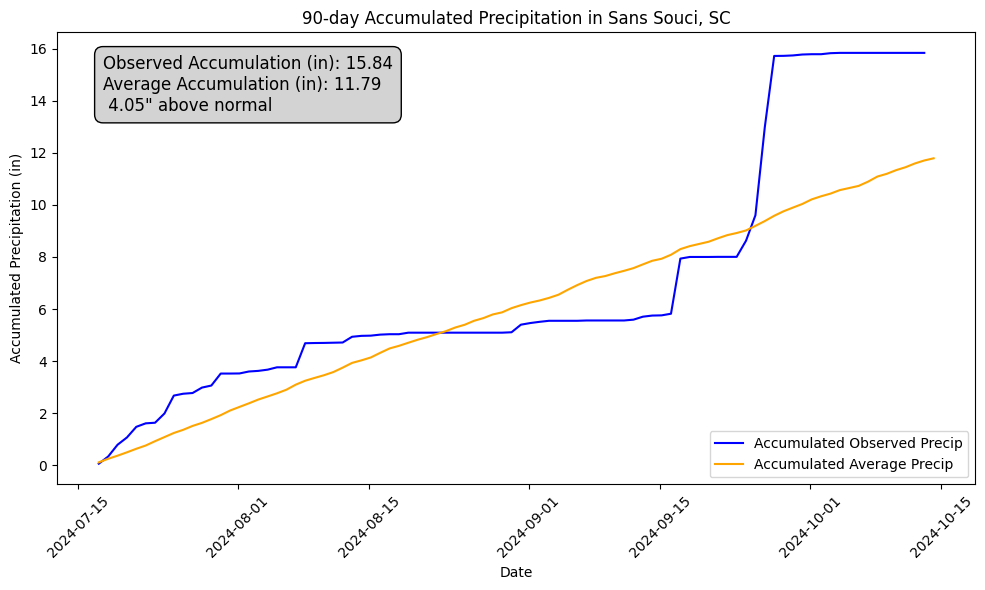

In [165]:
# Plot the data
plt.figure(figsize=(10, 6))

sum_observed = daily_period['Accumulated Observed Precip'].max()
sum_average = daily_period['Accumulated Average Precip'].max()

#Calculate difference
diff = sum_observed - sum_average

if diff >= 0:
    textstr = f'Observed Accumulation (in): {sum_observed:.2f}\nAverage Accumulation (in): {sum_average:.2f}\n {diff:.2f}" above normal'
else: 
    textstr = f'Observed Accumulation (in): {sum_observed:.2f}\nAverage Accumulation (in): {sum_average:.2f}\n {diff*-1:.2f}" below normal'


# Plot the accumulated observed precipitation
plt.plot(daily_period['date'], daily_period['Accumulated Observed Precip'], label='Accumulated Observed Precip', color='blue')
# Plot the accumulated average precipitation
plt.plot(daily_period['date'], daily_period['Accumulated Average Precip'], label='Accumulated Average Precip', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Accumulated Precipitation (in)')
plt.title(f'{period}-day Accumulated Precipitation in Sans Souci, SC')

# Show legend
plt.legend()

# Add a text box with the sum of both precipitation values
#textstr = f'Observed Accumulation (in): {sum_observed:.2f}\n  Average Accumulation (in): {sum_average:.2f}'

# Add the text box to the plot
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgrey'))


# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()